# The CRISP_DM Methodology
The CRISP_DM Methodology was used in our approach was used to approach the data given. The steps used in the process are as follows:

1. Business Underdstanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

## Business Understanding
Given the data at our disposal, that is Airbnb data for Boston, MA a few questions were raised. We sought to find out:
1. Can we adequately pridict pricing data given the listing information?
2. What are some of the main drivers of price?
3. Given these drivers, what are people typically looking for?

The last question is a bit vague, this is because it depends on the second business question. Depending on what the answer to number two is, it may change the last question.

## Data Understanding
There is quite a bit of here, 95 columns worth of features for us to choose from in our 3584 listings(rows). Since the initial question before us is in regards to predicting price we need to make sure we have the necessary data. Price is available along with data concerning the host, reviews, listing information (eg property type, number of rooms, location, url, etc). Off the bat, it seems the url data may not be necessarily helpful to calculating price. There are a few rows with some missing data. Some of these may be able to be imputed, others it may be safer to simply drop as there is no good way to guess. Some of the numerical data also seems to be in of type String and will need to be converted to an interger or float. And of course, the categorical data will need dummy variables. Airbnb data for Boston was provided by kaggle.com.



In [1]:
import read_data.read_data as rd
from clean_and_update.drop_data import drop_data
from clean_and_update.impute_data import impute_data
from clean_and_update.update_data import update
from analyze.predict_price import predict, calc_change
from analyze.bed_bath import bed_bath_chart


# gather data
df = rd.get_listing_data()

#assess what data is available
df.head

<bound method NDFrame.head of             id                            listing_url       scrape_id  \
0     12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1      3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2         6976      https://www.airbnb.com/rooms/6976  20160906204935   
3      1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4      7651065   https://www.airbnb.com/rooms/7651065  20160906204935   
...        ...                                    ...             ...   
3580   8373729   https://www.airbnb.com/rooms/8373729  20160906204935   
3581  14844274  https://www.airbnb.com/rooms/14844274  20160906204935   
3582  14585486  https://www.airbnb.com/rooms/14585486  20160906204935   
3583  14603878  https://www.airbnb.com/rooms/14603878  20160906204935   
3584  14504422  https://www.airbnb.com/rooms/14504422  20160906204935   

     last_scraped                                           name  \
0      2016-09-07        

## Data Preparation

### Choosing Data
Anything that cannot really be put into a more numerical format (text-based info) will likely not be helpful without more effort. Something like an NLP would be needed to get good use from things like summary, description, etc. This may expend more effort than it is worth and is not viable given current time constraints. There are a few columns which seem to have only the same data or no data at all, these will not really be helpful. As mentioned in the previous section, URL was thought to be unhelpful. Anything else not explicitly mentioned can be assummed to have been dropped. 

In regards to location, there are several columns dedicated to this. We have street, neighbourhood, neighbourhood_cleansed, city, state, zipcode market, smart_location, country_code, latitude, longitude. Some of this data is more precise and/or informative than others; as such we may not need the other features of location. In favor of ease of use to fit into a linear model, zip_code should be sufficent for our needs with the understanding that predicting any new zip codes will not be possible unless we have traing data for it. All other location information was therfore dropped. For zip_code being a categorical type we will create dummy variables in the update method.

In regards to information concerning the host, the host_id, the location of the host, when the host became a host, description of the host, the response times, rate, acceptance rate, host_verifications, if the host has a profile pic, and if the host is a super host. How good the host is may be a consideration to consumers, so all of these seem relavant. Who the host is (host_id) may not really be relevant to the price. This is because the other indicators about the host seem more important about telling us what type of person the host is.     

There is good amount of information about the property itself and what the consumer is paying for. These may all be considerations the consumer may look at before deciding to rent a place. Outside of location, which was discussed earlier, property_type, accomodates(how many the listing can accomadate), bathrooms, bedrooms, beds, guests_included, minimun_nights, maximum_nights, availability, various review scores, and cancellation policies are all likely considerations a consumer will have when choosing a listing. Other things the consumer may consider is how much information they may need to provide, whether or not a license is needed, guest verifications through various means such as through the phone, or a picture may also inform the consumer's choice as they may have extra steps before they can book a place to stay. 

Other historical data about the listing includes the number of reviews and reviews per month. These may not directly tell us anything, but perhaps places that are visited more often are able to fetch a higher price because of demand.

Last, but not least, is price and data concerning costs to the consumer. There is cost for the nightly, weekly, and monthly rate. The nightly rate will be used, the weekly and mothly rates will be discarded as some listings don't have these values, which may would further reduce the number of data points. Also, since we are predicting for price, having the weekly and monthly rates would not help since they would be based on price to begin with. Other costs include security deposit, cleaning fee, fees for extra peopele, 

### Cleaning Data
Now that we've decided what is initally going to be used to predict our data we need to clean it. First we need to drop data we won't use. This was somewhat already discussed above concerning data that is not useful and data that is related to the chosen data, but less helpful. 
> 'id', 'host_id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
                        'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
                        'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
                        'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_about',
                        'host_thumbnail_url', 'host_picture_url', 'street', 'neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state',
                        'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                        'is_location_exact', 'calendar_updated', 'calendar_last_scraped',
                        'first_review', 'last_review', 'jurisdiction_names', 'weekly_price',
                        'monthly_price', 'has_availability', 'license', 'square_feet', 'neighbourhood', 'host_location'

An entire row (the listing) was dropped if a desired feature value was null, where we could not infer the value. Those values are the following:
> 'price', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'property_type',
                 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'reviews_per_month',
                 'review_scores_value', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'zipcode',
                 'host_since', 'host_neighbourhood', 'host_listings_count',
                 'host_total_listings_count', 'calculated_host_listings_count', 'minimum_nights',
                 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365',
                 'number_of_reviews', 'instant_bookable', 'cancellation_policy'


Next, for other pieces of missing data that we thought we were able to infer, we replaced the null value with something else.
> 'host_is_superhost': 'f',  'host_has_profile_pic': 'f', 'host_verifications': '[]',
              'host_identity_verified': 'f', 'amenities': {}, 'security_deposit': '\\$0.00', 'cleaning_fee': '\\$0.00',
              'guests_included': 0, 'extra_people': '\\$0.00', 'requires_license': 'f',
              'require_guest_profile_picture': 'f', 'require_guest_phone_verification': 'f'
              
As you can tell, we replaced missing t/f values with the negative 'f'. Any amounts relating to cost that were missing was assummed to have none, and features that were groups of objects were assumed to have none as well.

Next we needed to make the data usable. Not all data was in the correct format that we were going to use in the linear regression model. For the host_since value, it was of type String and in the form YY-MM-DD. This was converted to a Date format and compared to the day the data was collected, that is the metadata information provided by kaggle (2016-11-16). The number of days was calculated, host_since was deleted and a new column was created called host_days.

For data that had multiple entries (e.g. an amenities entry could have {TV, Wirelesss Internet, Kitchen, Heating}), we would count the number of items inside and use that number instead creating new coluns for each item. Only the amenities and host_verification features were of this type. New columns were created and prefixed with 'number_of_'.

Next We had numerical values in the wrong format and needed to be converted to floats. These features were: 
> 'host_response_rate', 'host_acceptance_rate', 'price', 'security_deposit', 'cleaning_fee', 'extra_people'

As before, we would remove the original column and replace it with a new one prefixed with 'float_'.


Lastly, for all the categorical data, we created dummy variables instead.


> 'room_type', 'host_is_superhost', 'host_response_time', 'host_identity_verified', 'bed_type',
                'cancellation_policy', 'require_guest_phone_verification', 'require_guest_profile_picture', 'zipcode', 'host_has_profile_pic', 'property_type', 'requires_license', 'instant_bookable'
                

In [2]:
# clean and update data
drop_data(df)
impute_data(df)
df = update(df)
# show cleaned data
df.head

<bound method NDFrame.head of       float_extra_people  float_cleaning_fee  float_security_deposit  \
1                    0.0                10.0                    95.0   
2                   20.0                 0.0                     0.0   
4                    0.0                15.0                     0.0   
5                    0.0                30.0                     0.0   
6                   25.0                 0.0                     0.0   
...                  ...                 ...                     ...   
3573                30.0                25.0                     0.0   
3574                35.0                 0.0                   950.0   
3575                24.0                 0.0                    95.0   
3580                24.0                 0.0                    95.0   
3583                30.0                 0.0                   100.0   

      float_price  float_host_acceptance_rate  float_host_response_rate  \
1            65.0             

## Modeling
Our model uses linear regression to predict price. We used our cleaned data where 70% of the data was used to train our model and was tested against the remaining 30%. This method seemed appropriate given the correlation with 'float_price' (a new column made described in the previous section) and the other variables. Features were normalized.

In [3]:
# analyze correlation data when compared to price.
corr_price = df.corr()['float_price'].sort_values()

# display correlation of features to price
# Assess which features are good candidates as a primary predictor in our model
print(corr_price)

# train/fit model to data and predict price of a place
score = predict(df)

room_type_Private room       -0.564112
float_host_acceptance_rate   -0.180782
reviews_per_month            -0.177829
zipcode_02125                -0.138722
number_of_reviews            -0.131644
                                ...   
float_cleaning_fee            0.453444
beds                          0.529719
bedrooms                      0.571340
accommodates                  0.601533
float_price                   1.000000
Name: float_price, Length: 84, dtype: float64


## Evaluation
The clean data put into the model for training and the result was quite horrible. The model did not fit our data at all. In response to this, all categorical data was removed from the model and was trained again. The result was much better. Next, using the correlation data from above, categorical variables were added back in one at a time. If the model R2 score improved it was kept in, if not it was moved back out. Although this was not an exhaustive way of getting the best possible R2 score (as different combinations of variables go potentially result in better scores), it improved our values enough to reach a R2 score of .70. For Question 1, it seems like we can reliably to a moderate degree predict price.

Next we needed to identify the most influential features to answer our second question. To do this, one feature was removed, the model run again, the new R2 score recorded, and then added back in. We would do this with all the features. The top 5 changes from the original R2 score in both the positive and negative direction were then plotted in a bar graph. The top 3 features with highest change in R2 were, bedrooms, room_type_Private room, and bathrooms. It's no real surpise that those looking for private rooms would have an effect on the score as many people enjoy their privacy. That leaves more of a question about the bedroom and bathroom features which describe the number of bedrooms and bathrooms in the listing. There can be multiple combinations as bathrooms can come in the full or half variety along with total number of bedrooms. So our vague question number 3 becomes, "What combination of bedroom/bathroom number to people prefer?".

To evaluate question 3, we took the cleaned data and looked at only the bedrooms, bathrooms, and number_of_reviews features. The reason number_of_reviews was used is because we wanted to know how popular a listing was based on the combination of bedrooms and bathrooms. Since we don't have the total number of stays at the listing the number of reviews were used with the assumption that a certain percentage of people that use a listing leave a review and that percentage was consistent across all listings. It is a bit of a bold assumption, but without the actual data, this was used. A matrix was built with the total number of reviews for each combination. It seems that many more people stay in listings with one bedroom and one full bathroom. 

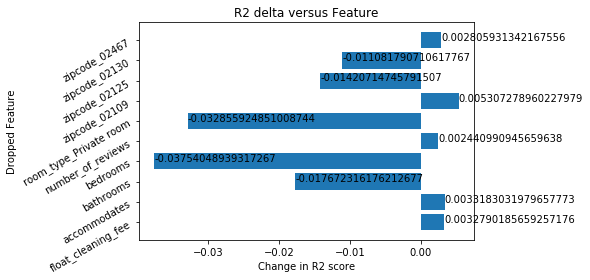

R2 score: 0.7047753011465256


In [4]:

# Calculate change in R2 based on feature and display
# Assess which features contribute most to R2
calc_change(df, score)
# Show R2 score
print("R2 score: " + str(score))

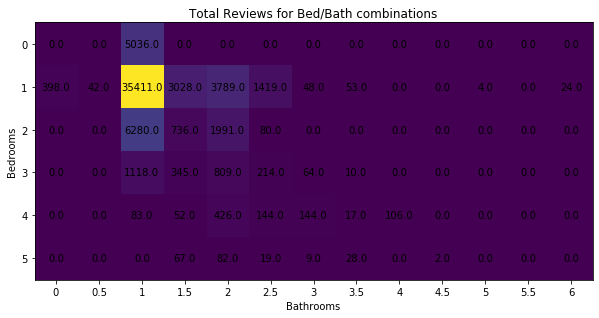

In [5]:
# analyze number of beds, bathrooms, and total reviews
# Visualize in Matrix format
# assess which combination is most prominent
new_df = bed_bath_chart(df)

## Deployment
The code is not intended to be deployed for use at this stage. More information, cleaning the data differntly, and more tuning may be able to get better results. The code may be used to better understand what motivates people to pick a certain type of property over another as well as how much they may pay for it. 